# Installation

## DuckDB

In [1]:
! pip install duckdb

## Les autres librairies utiles

In [2]:
! pip install -r requirements.txt

In [3]:
import duckdb
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import zipfile
import os

# Se connecter à DuckDB

In [ ]:
# Connexion à DuckDB
conn = duckdb.connect(database=':memory:', read_only=False)

# Exécution d'une requête SQL
cursor = conn.cursor()
cursor.execute("CREATE TABLE table_1(id INTEGER, name VARCHAR)")
cursor.execute("INSERT INTO table_1 VALUES (1, 'John'), (2, 'Alice'), (3, 'Bob')")

# Récupération des résultats de la requête
result = cursor.execute("SELECT * FROM table_1").fetchall()
print("Résultat de la requête : ", result)

# Fermeture de la connexion
conn.close()

Résultat de la requête :  [(1, 'John'), (2, 'Alice'), (3, 'Bob')]


# Convertir le fichier CSV en fichier parquet

In [4]:
# Charger le fichier CSV en utilisant pandas
df = pd.read_csv('pathologies.csv', on_bad_lines='skip', sep=";", low_memory=False)

# Créer un tableau PyArrow à partir du DataFrame pandas
df.to_parquet('pathologies.parquet')

### Charger le fichier parquet dans duckdb

In [5]:
conn = duckdb.connect(database=':memory:', read_only=False)

# Chargement du fichier Parquet
cursor = conn.cursor()
cursor.execute("CREATE TABLE pathologies AS SELECT * FROM parquet_scan('pathologies.parquet')")

# Affichage des 5 premières lignes
result = cursor.execute("SELECT * FROM pathologies LIMIT 5").fetchall()
print("Les 5 premières lignes du fichier Parquet : ", result)

Les 5 premières lignes du fichier Parquet :  [(2017, 'Pas de pathologies repérées, traitements, maternité, hospitalisations ni traitement antalgique ou anti-inflammatoire', None, None, 'sup_Petit_Conso_exclu', '45-49', 9.0, 75.0, '999', 230570.0, 393250.0, 58.632, '1', 'de 45 à 49 ans', 'tous sexes', 17.0), (2017, 'Pas de pathologies repérées, traitements, maternité, hospitalisations ni traitement antalgique ou anti-inflammatoire', None, None, 'sup_Petit_Conso_exclu', '45-49', 9.0, 76.0, '11', 14220.0, 24330.0, 58.451, '1', 'de 45 à 49 ans', 'tous sexes', 17.0), (2017, 'Pas de pathologies repérées, traitements, maternité, hospitalisations ni traitement antalgique ou anti-inflammatoire', None, None, 'sup_Petit_Conso_exclu', '45-49', 9.0, 76.0, '12', 10630.0, 17390.0, 61.133, '1', 'de 45 à 49 ans', 'tous sexes', 17.0), (2017, 'Pas de pathologies repérées, traitements, maternité, hospitalisations ni traitement antalgique ou anti-inflammatoire', None, None, 'sup_Petit_Conso_exclu', '45-49'

# Explorer les données

Le fichier contient des données sur les pathologies et les patients.

Ce fichier est disponible en OpenData :
https://www.data.gouv.fr/fr/datasets/pathologies-effectif-de-patients-par-pathologie-sexe-classe-dage-et-territoire-departement-region/

### Le requeter en SQL

Les lignes et les colonnes

In [6]:
# Nombre total de lignes dans la table
total_rows = conn.execute("SELECT COUNT(*) AS total_rows FROM pathologies").fetchall()
print("Nombre total de lignes : ", total_rows)

# Nombre de colonnes dans la table
total_columns = conn.execute("SELECT COUNT(*) AS total_columns FROM information_schema.columns WHERE table_name = 'pathologies'").fetchall()
print("Nombre total de colonnes : ", total_columns)

Nombre total de lignes :  [(472780,)]
Nombre total de colonnes :  [(16,)]


Le schéma de la table

In [7]:
# Statistiques de base sur les colonnes
column_stats = conn.execute("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = 'pathologies'
""").fetchall()

for column in column_stats:
    print(column)

Statistiques de base sur les colonnes :
('annee', 'BIGINT')
('patho_niv1', 'VARCHAR')
('patho_niv2', 'VARCHAR')
('patho_niv3', 'VARCHAR')
('top', 'VARCHAR')
('cla_age_5', 'VARCHAR')
('sexe', 'DOUBLE')
('region', 'DOUBLE')
('dept', 'VARCHAR')
('ntop', 'DOUBLE')
('npop', 'DOUBLE')
('prev', 'DOUBLE')
('niveau_prioritaire', 'VARCHAR')
('libelle_classe_age', 'VARCHAR')
('libelle_sexe', 'VARCHAR')
('tri', 'DOUBLE')


Les statistiques basiques

In [8]:
# Statistiques de base sur les données (pour les colonnes numériques)
numeric_columns_query = """
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = 'pathologies'
    AND data_type IN ('INTEGER', 'DOUBLE', 'FLOAT', 'DECIMAL')
"""
numeric_columns = conn.execute(numeric_columns_query).fetchall()

# Construction de la requête SQL pour les statistiques des colonnes numériques
stats_queries = []
for column in numeric_columns:
    column_name = column[0]
    stats_queries.append(f"""
        SELECT
            '{column_name}' AS column_name,
            AVG({column_name}) AS average,
            STDDEV({column_name}) AS standard_deviation,
            MIN({column_name}) AS min_value,
            MAX({column_name}) AS max_value
        FROM pathologies
    """)

# Exécution des requêtes de statistiques et affichage des résultats
print("Statistiques des colonnes numériques :")
print("Nom de colonne / Moyenne / Ecart type / Minimum / Maximum")
for query in stats_queries:
    result = conn.execute(query).fetchall()
    print(result)


Statistiques des colonnes numériques :
Nom de colonne / Moyenne / Ecart type / Minimum / Maximum
[('sexe', 4.063953771212343, 3.5788572586670435, 1.0, 9.0)]
[('region', 51.00494734326186, 29.445641450205613, 1.0, 99.0)]
[('ntop', 6767.448756230075, 173859.415181297, 10.0, 65117980.0)]
[('npop', 99567.82162490296, 923159.8726480149, 10.0, 65509600.0)]
[('prev', 7.650258876453789, 18.9051137320588, 0.0, 100.0)]
[('tri', 38.92027459914663, 22.892944717512286, 1.0, 78.0)]


In [9]:
# Statistiques de base sur les données (pour les colonnes numériques)
get_disease_query = """
    SELECT DISTINCT patho_niv1
    FROM pathologies
"""
diseases = conn.execute(get_disease_query).fetchall()
for disease in diseases :
    print(disease)

[('Pas de pathologies repérées, traitements, maternité, hospitalisations ni traitement antalgique ou anti-inflammatoire',), ('Traitements du risque vasculaire (hors pathologies)',), ('Maladies inflammatoires ou rares ou VIH ou SIDA',), ('Traitement antalgique ou anti-inflammatoire (hors pathologies, traitements, maternité ou hospitalisations)',), ('Cancers',), ('Maladies respiratoires chroniques (hors mucoviscidose)',), ('Insuffisance rénale chronique terminale',), ('Maladies du foie ou du pancréas (hors mucoviscidose)',), ('Diabète',), ('Maladies cardio-neurovasculaires',), ('Séjours en hospitalisation complète pour prise en charge de la Covid-19',), ('Maladies neurologiques ou dégénératives',), ('Traitements psychotropes (hors pathologies)',), ('Maladies psychiatriques',), ('Autres affections de longue durée (dont 31 et 32)',), (None,), ('Maternité (avec ou sans pathologies)',), ('Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)',)]


# Récupérer des données aggrégées et passer en pandas

In [ ]:
query = (f"""
        SELECT patho_niv1, dept, SUM(ntop), SUM(npop)
        FROM pathologies
        WHERE annee = 2018
        GROUP BY dept, patho_niv1
    """)

# Exécution des requêtes de statistiques et affichage des résultats
result = (conn.execute(query).fetchall())
df = pd.DataFrame(result, columns=["patho_niv1", "departement", "malades", "pop"])
df.insert(1, 'perc', df['malades']/df['pop'] * 100)
print(df)

Statistiques par maladies en 2018:
[('Maladies cardio-neurovasculaires', '68', 230020.0, 13980490.0), ('Maladies cardio-neurovasculaires', '47', 112990.0, 6546340.0), ('Maladies cardio-neurovasculaires', '11', 214860.0, 8920880.0), ('Maladies cardio-neurovasculaires', '31', 409150.0, 25757770.0), ('Maladies cardio-neurovasculaires', '81', 175600.0, 7723160.0)]
                                   patho_niv1      perc departement   malades  \
0            Maladies cardio-neurovasculaires  1.645293          68  230020.0   
1            Maladies cardio-neurovasculaires  1.726003          47  112990.0   
2            Maladies cardio-neurovasculaires  2.408507          11  214860.0   
3            Maladies cardio-neurovasculaires  1.588453          31  409150.0   
4            Maladies cardio-neurovasculaires  2.273681          81  175600.0   
...                                       ...       ...         ...       ...   
1730  Insuffisance rénale chronique terminale  0.114434          73   

# Mettre ces données sous forme de carte

### Extraire les données géographiques de GADM

In [41]:
zip_path = 'gadm41_FRA_shp.zip'
extracted_path = 'extracted_shapefile'

if not os.path.exists(extracted_path):
    os.makedirs(extracted_path)

# Extraire les fichiers du zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Trouver le fichier shapefile (.shp)
shapefile_path = None
for root, dirs, files in os.walk(extracted_path):
    for file in files:
        if file.endswith('.shp'):
            shapefile_path = os.path.join(root, file)
            break

### Faire la jointure sur les données géographiques

In [53]:
disease_to_plot = 'Maladies cardio-neurovasculaires'
df_filtered = df[df['patho_niv1'] == disease_to_plot]

gdf = gpd.read_file('extracted_shapefile/gadm41_FRA_2.shp')
#gdf = gpd.read_file('france.shp')

gdf['code'] = gdf['CC_2'].astype(str).str.zfill(2)
df_filtered['departement'] = df_filtered['departement'].astype(str).str.zfill(2)

# Joindre les données géographiques avec les données de patients
merged = gdf.set_index('code').join(df_filtered.set_index('departement'))
print(merged.columns)

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry', 'patho_niv1', 'perc', 'malades', 'pop'],
      dtype='object')


<ipython-input-53-95e56c34ce1b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['departement'] = df_filtered['departement'].astype(str).str.zfill(2)


### Afficher la carte

<ipython-input-51-fba844c21da8>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')  # Utilisation de 'RdYlGn_r' pour aller du vert au rouge


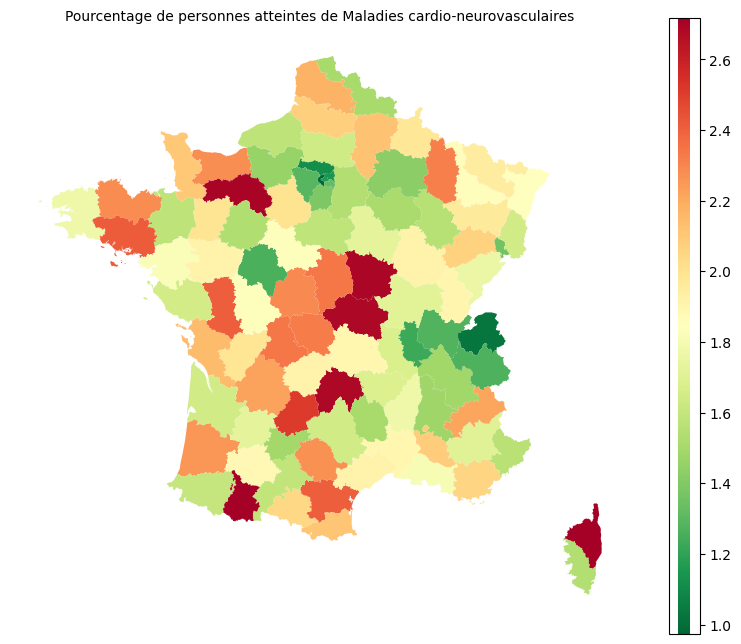

In [51]:
variable_to_plot = "perc"

# Définir les valeurs de coloration
norm = mcolors.Normalize(vmin=merged[variable_to_plot].min(), vmax=merged[variable_to_plot].max())
cmap = plt.cm.get_cmap('RdYlGn_r')  # Utilisation de 'RdYlGn_r' pour aller du vert au rouge

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column=variable_to_plot, cmap=cmap, norm=norm, legend=True, ax=ax)

# Supprimer les axes gradués
ax.set_axis_off()

# Ajuster la taille de la barre colorée (legend)
cbar = ax.get_figure().get_axes()[1]
cbar.set_aspect(30)  # Ajuster la taille selon vos besoins

# Ajouter un titre
ax.set_title(f'Pourcentage de personnes atteintes de {disease_to_plot}', fontdict={'fontsize': '10', 'fontweight': '3'})

# Afficher la carte
plt.show()

# Fermer la connexion

In [ ]:
conn.close()